In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

In [20]:
n = 500
c1 = np.random.randn(n, 2) * 0.4 + np.array([2, 2])
c2 = np.random.randn(n, 2) * 0.4 + np.array([-2, 2])
c3 = np.random.randn(n, 2) * 0.4 + np.array([0, -2])
X1 = np.vstack([c1, c2, c3])
y1 = np.array([0]*n + [1]*n + [2]*n)
data1 = np.hstack([X1, y1.reshape(-1,1)])
np.savetxt("dataset1_linear.txt", data1)

In [21]:
n = 500
theta1 = 2 * np.pi * np.random.rand(n)
theta2 = 2 * np.pi * np.random.rand(n)
r1 = 1 + 0.1 * np.random.randn(n)
r2 = 2 + 0.1 * np.random.randn(n)
x1 = np.column_stack([r1 * np.cos(theta1), r1 * np.sin(theta1)])
x2 = np.column_stack([r2 * np.cos(theta2), r2 * np.sin(theta2)])
X2 = np.vstack([x1, x2])
y2 = np.array([0]*n + [1]*n)
data2 = np.hstack([X2, y2.reshape(-1,1)])
np.savetxt("dataset2_nonlinear.txt", data2)

In [22]:
def load_data(path):
    data = np.loadtxt(path)
    X = data[:, :2]
    y = data[:, 2].astype(int)
    return X, y
def one_hot(y, c):
    o = np.zeros((len(y), c))
    o[np.arange(len(y)), y] = 1
    return o

In [23]:
def split_data(X, y, c):
    Xtr, Ytr, Xv, Yv, Xte, Yte = [], [], [], [], [], []
    for i in range(c):
        idx = np.where(y == i)[0]
        np.random.shuffle(idx)
        n = len(idx)
        t = int(0.6*n)
        v = int(0.8*n)
        Xtr.append(X[idx[:t]])
        Ytr.append(y[idx[:t]])
        Xv.append(X[idx[t:v]])
        Yv.append(y[idx[t:v]])
        Xte.append(X[idx[v:]])
        Yte.append(y[idx[v:]])
    return (np.vstack(Xtr), np.hstack(Ytr),
            np.vstack(Xv), np.hstack(Yv),
            np.vstack(Xte), np.hstack(Yte))

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)
class FCNN:
    def __init__(self, layers):
        self.W = []
        self.B = []
        for i in range(len(layers)-1):
            self.W.append(np.random.randn(layers[i], layers[i+1]) * 0.1)
            self.B.append(np.zeros((1, layers[i+1])))
    def forward(self, x):
        a = x
        Z = []
        A = [x]
        for w, b in zip(self.W, self.B):
            z = a @ w + b
            a = sigmoid(z)
            Z.append(z)
            A.append(a)
        return Z, A
    def backward(self, Z, A, y, lr):
        delta = (A[-1] - y) * dsigmoid(Z[-1])
        for i in reversed(range(len(self.W))):
            self.W[i] -= lr * A[i].T @ delta
            self.B[i] -= lr * np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                delta = (delta @ self.W[i].T) * dsigmoid(Z[i-1])

In [25]:
def train(model, X, Y, Xv, Yv, lr, epochs):
    tr_loss = []
    v_loss = []
    for _ in range(epochs):
        err = 0
        for x, y in zip(X, Y):
            Z, A = model.forward(x.reshape(1,-1))
            err += 0.5 * np.sum((A[-1] - y)**2)
            model.backward(Z, A, y.reshape(1,-1), lr)
        tr_loss.append(err / len(X))
        ve = 0
        for x, y in zip(Xv, Yv):
            _, A = model.forward(x.reshape(1,-1))
            ve += 0.5 * np.sum((A[-1] - y)**2)
        v_loss.append(ve / len(Xv))
    return tr_loss, v_loss

In [26]:
def predict(model, X):
    p = []
    for x in X:
        _, A = model.forward(x.reshape(1,-1))
        p.append(np.argmax(A[-1]))
    return np.array(p)
def confusion(y, yp, c):
    m = np.zeros((c,c), int)
    for t, p in zip(y, yp):
        m[t, p] += 1
    return m
def accuracy(y, yp):
    return np.mean(y == yp)

In [27]:
def plot_decision(model, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(model, grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.show()

In [28]:
def plot_neurons(model, X):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 50),
                         np.linspace(X[:,1].min(), X[:,1].max(), 50))
    grid = np.c_[xx.ravel(), yy.ravel()]
    _, A = model.forward(grid)
    for i in range(A[1].shape[1]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xx, yy, A[1][:,i].reshape(xx.shape))
        plt.show()

In [29]:
class Perceptron:
    def __init__(self):
        self.w = np.random.randn(2)
        self.b = 0
    def train(self, X, y, lr, epochs):
        for _ in range(epochs):
            for xi, yi in zip(X, y):
                yp = 1 if xi @ self.w + self.b >= 0 else 0
                self.w += lr * (yi - yp) * xi
                self.b += lr * (yi - yp)
    def predict(self, X):
        return np.array([1 if x @ self.w + self.b >= 0 else 0 for x in X])

In [30]:
X, y = load_data("dataset1_linear.txt")
c = 3
Xtr, Ytr, Xv, Yv, Xte, Yte = split_data(X, y, c)
Ytr_oh = one_hot(Ytr, c)
Yv_oh = one_hot(Yv, c)
Yte_oh = one_hot(Yte, c)
model = FCNN([2, 8, c])
tr_loss, v_loss = train(model, Xtr, Ytr_oh, Xv, Yv_oh, 0.1, 100)

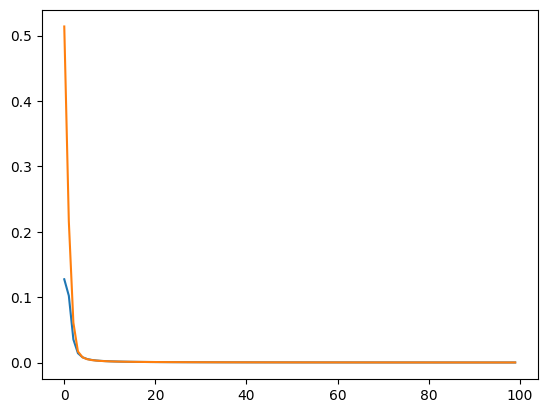

[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Validation accuracy: 1.0


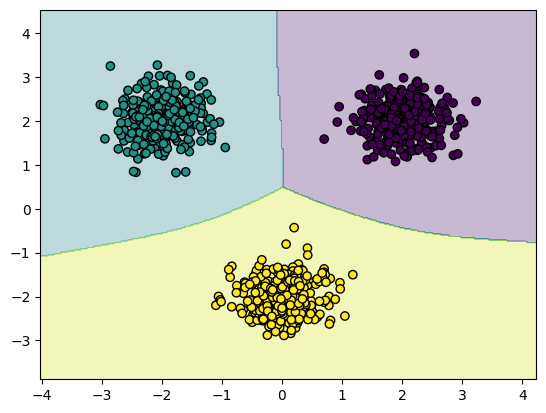

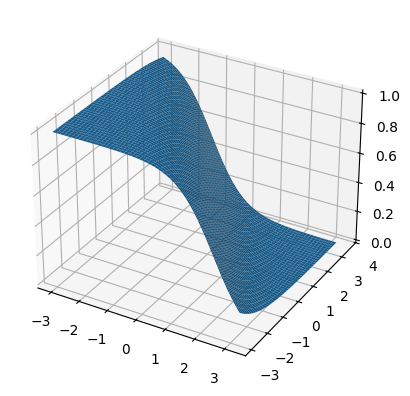

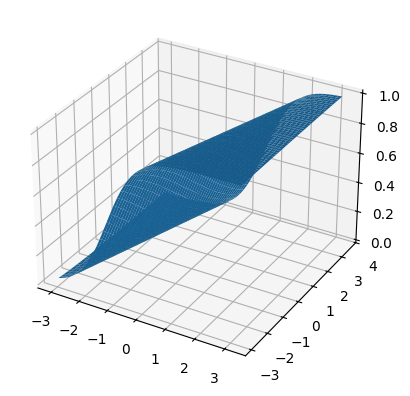

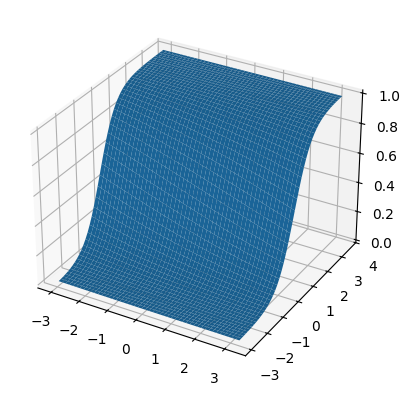

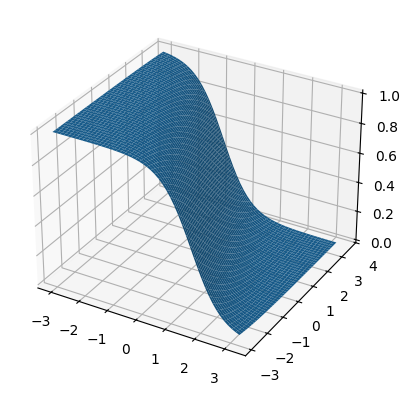

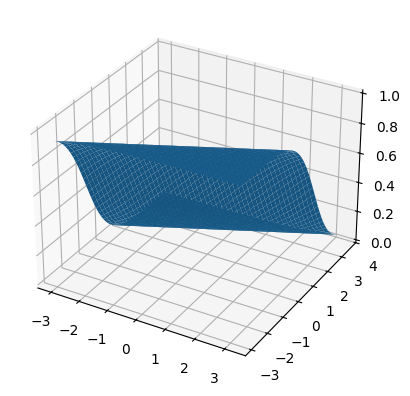

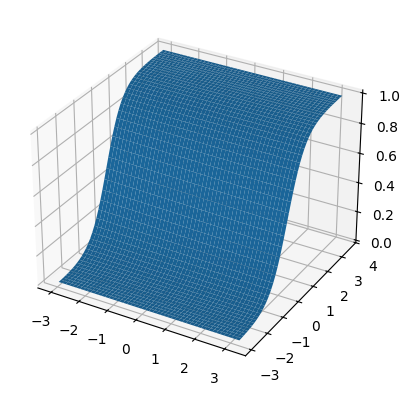

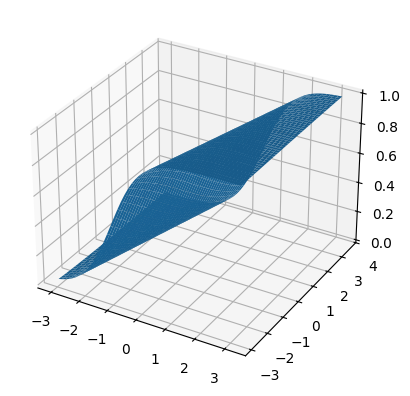

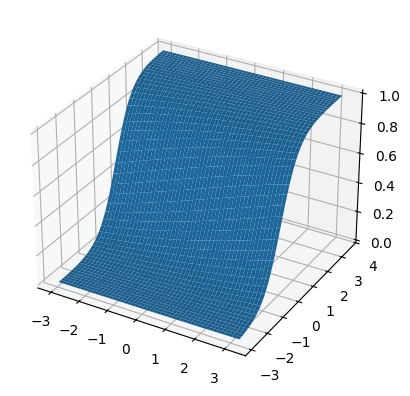

In [31]:
plt.plot(tr_loss)
plt.plot(v_loss)
plt.show()
yp = predict(model, Xv)
print(confusion(Yv, yp, c))
print("Validation accuracy:", accuracy(Yv, yp))
plot_decision(model, Xtr, Ytr)
plot_neurons(model, Xtr)

In [32]:
X, y = load_data("dataset2_nonlinear.txt")
c = 2
Xtr, Ytr, Xv, Yv, Xte, Yte = split_data(X, y, c)
Ytr_oh = one_hot(Ytr, c)
Yv_oh = one_hot(Yv, c)
Yte_oh = one_hot(Yte, c)
model = FCNN([2, 16, 8, c])
tr_loss, v_loss = train(model, Xtr, Ytr_oh, Xv, Yv_oh, 0.1, 150)

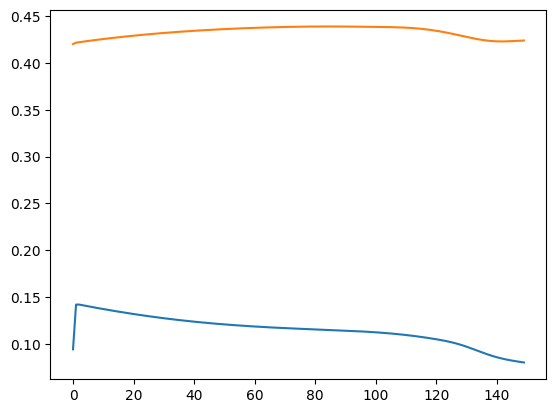

[[  0 100]
 [  0 100]]
Validation accuracy: 0.5


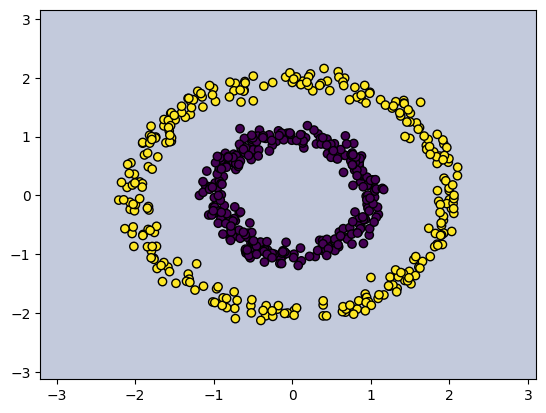

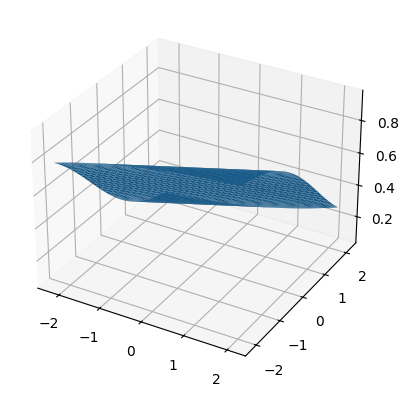

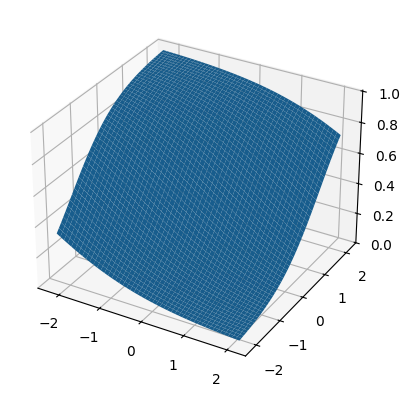

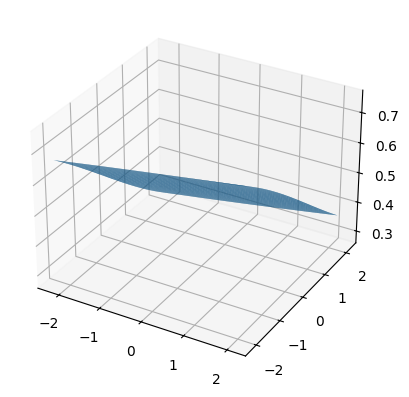

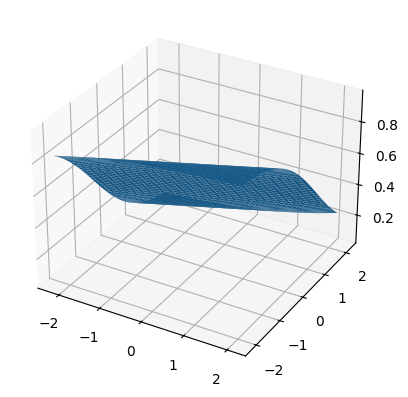

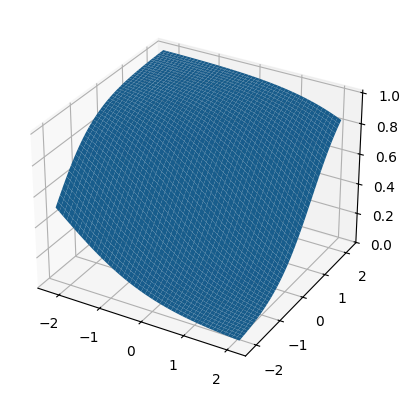

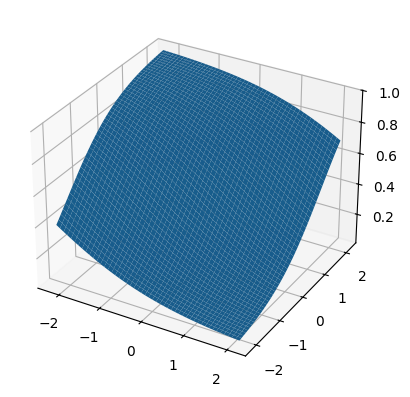

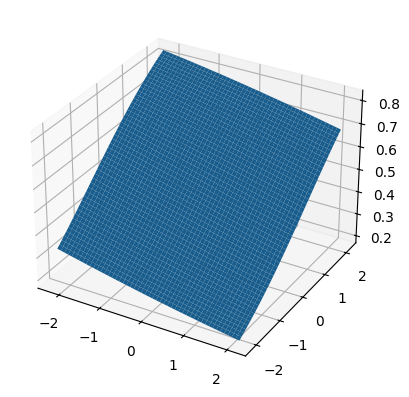

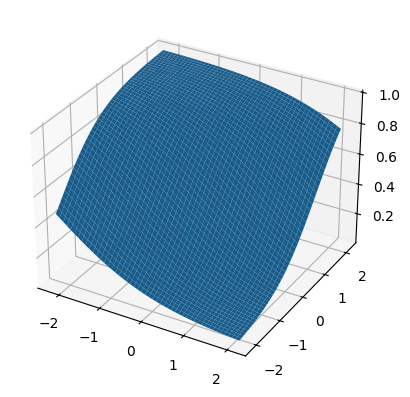

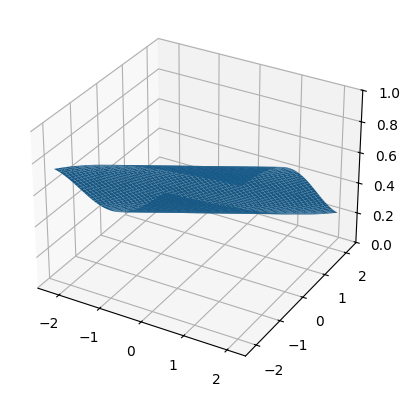

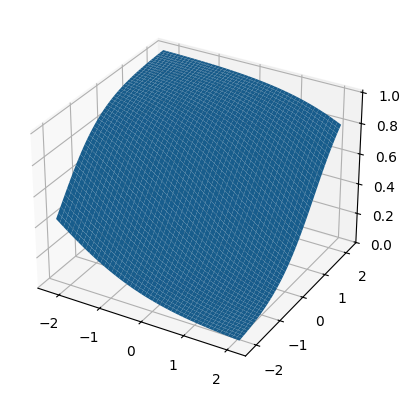

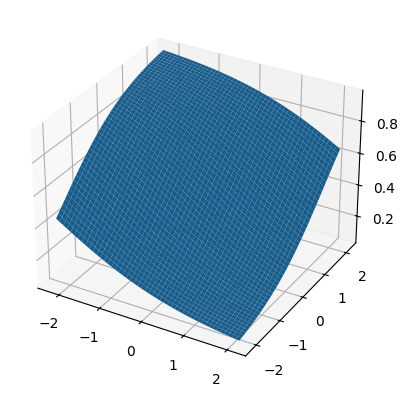

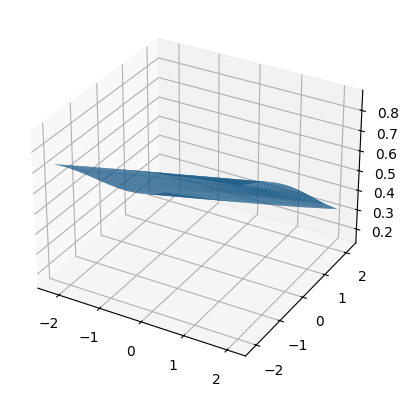

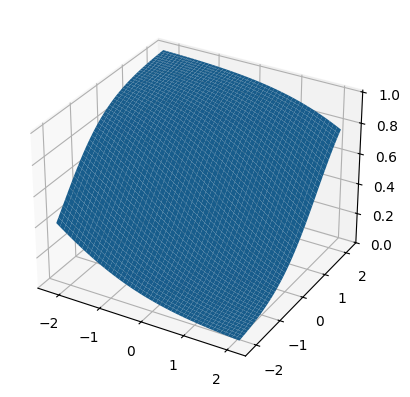

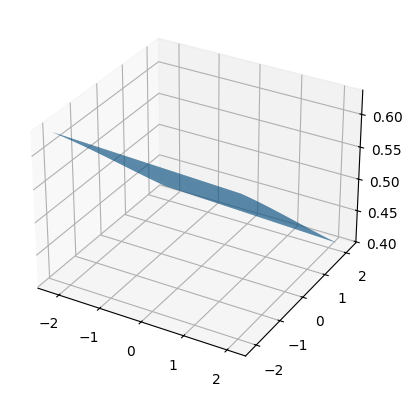

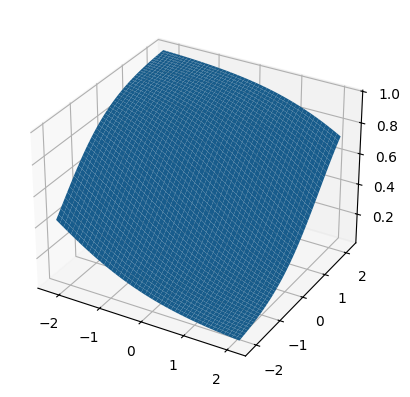

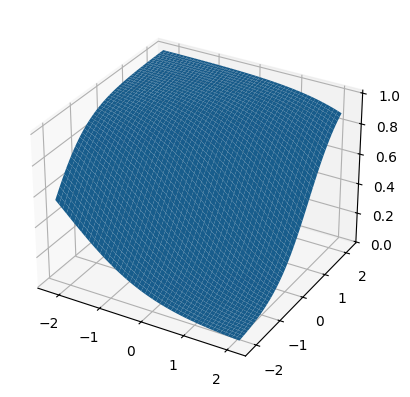

In [33]:
plt.plot(tr_loss)
plt.plot(v_loss)
plt.show()
yp = predict(model, Xv)
print(confusion(Yv, yp, c))
print("Validation accuracy:", accuracy(Yv, yp))
plot_decision(model, Xtr, Ytr)
plot_neurons(model, Xtr)

In [34]:
p = Perceptron()
p.train(Xtr, Ytr, 0.01, 50)
yp = p.predict(Xte)
print("Perceptron accuracy:", accuracy(Yte, yp))

Perceptron accuracy: 0.5
